In [281]:
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Preparing a dataset

## Actigraphy dataset

In [282]:
actigraphy_df = pd.read_parquet("series_train.parquet")

In [283]:
# Removing irrelevant columns
actigraphy_df.drop(
    columns=["step", "X", "Y", "Z", "anglez", "battery_voltage"],
    inplace=True,
)

In [284]:
# Taking means after aggregations
actigraphy_df = actigraphy_df.groupby("id", observed=True).agg(
    {"enmo": "mean", "non-wear_flag": "mean", "light": "mean"}
)

actigraphy_df.reset_index(inplace=True)
display(actigraphy_df)

,id,enmo,non-wear_flag,light
0,00115b9f,0.047388,0.000000,42.296310
1,001f3379,0.011926,0.655708,16.771980
2,00f332d1,0.030255,0.171246,66.563393
3,01085eb3,0.032946,0.035210,17.800735
4,012cadd8,0.058280,0.000000,54.893402
...,...,...,...,...
991,fe9c71d8,0.043686,0.137257,7.297878
992,fecc07d6,0.002962,0.939101,50.648312
993,ff18b749,0.053595,0.000000,94.217117
994,ffcd4dbd,0.028601,0.020323,22.480034


## HBN dataset

In [285]:
hbn_df = pd.read_csv("train.csv")

In [286]:
# Taking only rows that have a target
hbn_df = hbn_df[~hbn_df["sii"].isna()]

In [287]:
# As sii column is calculated from PCIAT Total and that is calculated from PCIAT questions, we can drop all PCIAT columns. We will only keep the season column
columns_to_drop = hbn_df.filter(regex="^PCIAT").columns.difference(["PCIAT-Season"])
hbn_df.drop(columns=columns_to_drop, inplace=True)

In [288]:
# Knowing that BMI is calculated from weight and height we can get rid of those two columns
hbn_df.drop(columns=["Physical-Weight", "Physical-Height"], inplace=True)

In [289]:
hbn_df["Physical-BMI"] = hbn_df["Physical-BMI"].fillna(hbn_df["BIA-BIA_BMI"])

In [290]:
# To not create bias in data, we will drop columns with a high number of null columns
high_null_columns = hbn_df.columns[hbn_df.isnull().mean() > 0.5]
hbn_df.drop(columns=high_null_columns, inplace=True)

In [291]:
hbn_df.drop(columns=["BIA-BIA_BMI"], inplace=True)

In [292]:
# We ill be using the average value to fill the missing values by first apply log on the current columns and then filling the missing values
hbn_df["Physical-BMI"] = hbn_df["Physical-BMI"].fillna(hbn_df["Physical-BMI"].mean())

In [293]:
# Converting seasons to numeric values
season_mapping = {"Spring": 0, "Summer": 1, "Fall": 2, "Winter": 3}
season_cols = hbn_df.filter(regex="Season$").columns
hbn_df[season_cols] = hbn_df[season_cols].replace(season_mapping)

/var/folders/md/j2f882mn1vl7cb0f7l2mmkjh0000gp/T/ipykernel_84485/2726629741.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hbn_df[season_cols] = hbn_df[season_cols].replace(season_mapping)


In [294]:
# As the null percentage is around 50%, we can drop the columns as we can assume the corelation is not from missing values
bia_corr_matrix = hbn_df.filter(regex="^BIA").corr()

high_corr_threshold = 0.9
high_corr_pairs = bia_corr_matrix.columns[
    (bia_corr_matrix.abs() > high_corr_threshold).sum() > 1
]

hbn_df.drop(columns=high_corr_pairs, inplace=True)

Fill in na values with mode or mean depending on the number of unique values. \
For columns with a lot of unique values, we take the mean value after grouping by age and sex. \
For columns with a small number of unique values, 

In [295]:
hbn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      2736 non-null   object 
 1   Basic_Demos-Enroll_Season               2736 non-null   int64  
 2   Basic_Demos-Age                         2736 non-null   int64  
 3   Basic_Demos-Sex                         2736 non-null   int64  
 4   CGAS-Season                             2342 non-null   float64
 5   CGAS-CGAS_Score                         2342 non-null   float64
 6   Physical-Season                         2595 non-null   float64
 7   Physical-BMI                            2736 non-null   float64
 8   Physical-Diastolic_BP                   2478 non-null   float64
 9   Physical-HeartRate                      2486 non-null   float64
 10  Physical-Systolic_BP                    2478 non-null   float64
 

In [296]:
columns = set(hbn_df.columns.to_list()) - {
    "id",
    "Basic_Demos-Enroll_Season",
    "Basic_Demos-Age",
    "Basic_Demos-Sex",
    "sii",
}

for col in columns:
    if len(hbn_df[col].unique()) > 10:
        hbn_df[col] = hbn_df.groupby(["Basic_Demos-Age", "Basic_Demos-Sex"])[
            col
        ].transform(lambda x: x.fillna(x.mean()))
        hbn_df[col] = hbn_df[col].fillna(hbn_df[col].mean())

    if len(hbn_df[col].unique()) <= 10:
        hbn_df[col] = hbn_df[col].fillna(hbn_df[col].mode())
        hbn_df[col] = hbn_df[col].fillna(hbn_df[col].median())

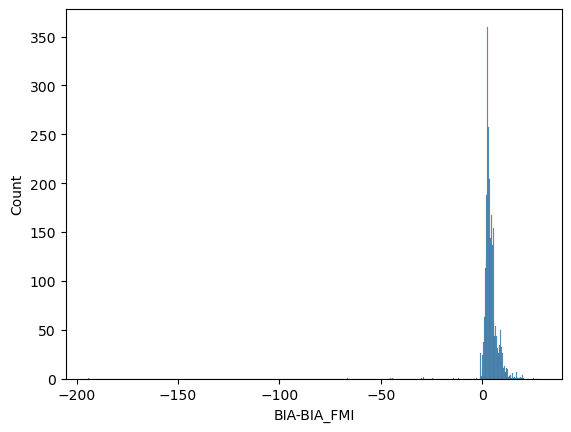

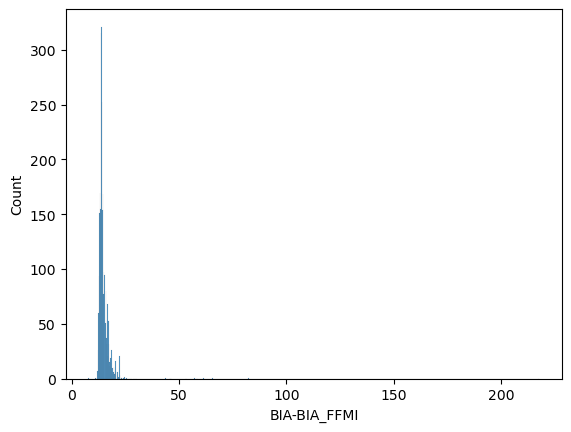

In [297]:
for col in columns:
    if 'FMI' in col:
        sns.histplot(hbn_df[col])
        #plt.xlim((0, 25))
        plt.show()

In [298]:
# Removing outliers from FMI and FFMI

hbn_df['BIA-BIA_FFMI'] = hbn_df['BIA-BIA_FFMI'].apply(lambda x: hbn_df['BIA-BIA_FFMI'].median() if x > 24 else x)
hbn_df['BIA-BIA_FMI'] = hbn_df['BIA-BIA_FMI'].apply(lambda x: hbn_df['BIA-BIA_FMI'].median() if x <= 0 or x > 9 else x)

### Combining data sources

In [317]:
df = pd.merge(left=hbn_df, right=actigraphy_df, how='left', on='id')

In [318]:
# Filling in missing values

nan_columns = {"enmo", "non-wear_flag", "light"}

for col in nan_columns:
    df[col] = df[col].fillna(df[col].mean())

In [319]:
df = df.drop(
    columns=["id", "Basic_Demos-Enroll_Season", "Basic_Demos-Age", "Basic_Demos-Sex"]
)

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   CGAS-Season                             2736 non-null   float64
 1   CGAS-CGAS_Score                         2736 non-null   float64
 2   Physical-Season                         2736 non-null   float64
 3   Physical-BMI                            2736 non-null   float64
 4   Physical-Diastolic_BP                   2736 non-null   float64
 5   Physical-HeartRate                      2736 non-null   float64
 6   Physical-Systolic_BP                    2736 non-null   float64
 7   FGC-Season                              2736 non-null   float64
 8   FGC-FGC_CU                              2736 non-null   float64
 9   FGC-FGC_CU_Zone                         2736 non-null   float64
 10  FGC-FGC_PU                              2736 non-null   floa

# Training and testing models

Imports

In [321]:
# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# For classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# For regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# For model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Train test split

In [322]:
X = df.drop('sii', axis=1)
y = df['sii']

In [323]:
y = y.astype(int)

In [324]:
# For reproducibility
random_state = 42

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

Classification models

In [325]:
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC()
}

In [326]:
for model_name, model in classification_models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))

/Users/mhv/.pyenv/versions/anaconda3-2023.07-2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression ===
Accuracy: 0.5985401459854015

=== Decision Tree ===
Accuracy: 0.4981751824817518

=== Random Forest ===
Accuracy: 0.6076642335766423

=== Gradient Boosting ===
Accuracy: 0.6058394160583942

=== K-Nearest Neighbors ===
Accuracy: 0.5492700729927007

=== Support Vector Machine ===
Accuracy: 0.6131386861313869


Regression models

In [327]:
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Support Vector Regressor': SVR()
}

In [328]:
for model_name, model in regression_models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n=== {model_name} ===")
    print("RMSE:", rmse)
    print("R^2 Score:", r2)


=== Linear Regression ===
RMSE: 0.6907018882756307
R^2 Score: 0.21625331765361022

=== Ridge Regression ===
RMSE: 0.6897315476074197
R^2 Score: 0.21845388230465412

=== Lasso Regression ===
RMSE: 0.7471564688815744
R^2 Score: 0.08289818975618546

=== Decision Tree Regressor ===
RMSE: 0.9862189093838535
R^2 Score: -0.597868662333968

=== Random Forest Regressor ===
RMSE: 0.6895666681192051
R^2 Score: 0.21882749294295278

=== Gradient Boosting Regressor ===
RMSE: 0.6832186107287782
R^2 Score: 0.23314402686304658

=== K-Nearest Neighbors Regressor ===
RMSE: 0.7863340052949584
R^2 Score: -0.015800783386945128

=== Support Vector Regressor ===
RMSE: 0.7276366599460922
R^2 Score: 0.13019165067968475


Hyperparameter tuning

In [329]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", np.sqrt(-grid_search.best_score_))

Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Best Score: 0.6846309945255571


Feature importance

In [330]:
# Fit a model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df.head(20))


Feature Importances:
                                   Feature  Importance
8                               FGC-FGC_CU    0.107551
30  PreInt_EduHx-computerinternet_hoursday    0.076677
20                            BIA-BIA_FFMI    0.061117
28                         SDS-SDS_Total_T    0.060603
3                             Physical-BMI    0.057595
21                             BIA-BIA_FMI    0.053006
5                       Physical-HeartRate    0.049847
6                     Physical-Systolic_BP    0.048285
24                       PAQ_C-PAQ_C_Total    0.047046
1                          CGAS-CGAS_Score    0.042821
27                       SDS-SDS_Total_Raw    0.041871
4                    Physical-Diastolic_BP    0.036744
10                              FGC-FGC_PU    0.036498
16                              FGC-FGC_TL    0.032446
14                             FGC-FGC_SRR    0.032360
12                             FGC-FGC_SRL    0.031360
33                                   light 